In [257]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
from pandas import ExcelWriter
from pandas import ExcelFile
rcParams['figure.figsize'] = 12, 10

In [258]:
Hospital_Information=pd.read_csv('data/Hospital_General_Information.csv')

In [259]:
Hospital_Information.head()

,Provider ID,Hospital Name,Address,City,State,ZIP Code,County Name,Phone Number,Hospital Type,Hospital Ownership,...,Readmission national comparison footnote,Patient experience national comparison,Patient experience national comparison footnote,Effectiveness of care national comparison,Effectiveness of care national comparison footnote,Timeliness of care national comparison,Timeliness of care national comparison footnote,Efficient use of medical imaging national comparison,Efficient use of medical imaging national comparison footnote,Location
0,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,MARSHALL,2565938310,Acute Care Hospitals,Government - Hospital District or Authority,...,NaN,Same as the national average,NaN,Above the national average,NaN,Above the national average,NaN,Below the national average,NaN,"2505 U S HIGHWAY 431 NORTH BOAZ, AL 35957"
1,10012,DEKALB REGIONAL MEDICAL CENTER,200 MED CENTER DRIVE,FORT PAYNE,AL,35968,DE KALB,2568453150,Acute Care Hospitals,Proprietary,...,NaN,Below the national average,NaN,Same as the national average,NaN,Above the national average,NaN,Same as the national average,NaN,"200 MED CENTER DRIVE FORT PAYNE, AL 35968"
2,10131,CRESTWOOD MEDICAL CENTER,ONE HOSPITAL DR SE,HUNTSVILLE,AL,35801,MADISON,2568823100,Acute Care Hospitals,Proprietary,...,NaN,Below the national average,NaN,Same as the national average,NaN,Below the national average,NaN,Same as the national average,NaN,"ONE HOSPITAL DR SE HUNTSVILLE, AL 35801"
3,11304,CHOCTAW GENERAL HOSPITAL,"401 VANITY FAIR LANE, PO BOX 618",BUTLER,AL,36904,CHOCTAW,2054599100,Critical Access Hospitals,Voluntary non-profit - Private,...,Results are not available for this reporting p...,Not Available,There are too few measures or measure groups r...,Same as the national average,NaN,Same as the national average,NaN,Not Available,Results are not available for this reporting p...,"401 VANITY FAIR LANE, PO BOX 618 BUTLER, AL 36904"
4,21301,PROVIDENCE VALDEZ MEDICAL CENTER,PO BOX 550,VALDEZ,AK,99686,NaN,9078352249,Critical Access Hospitals,Government - Local,...,There are too few measures or measure groups r...,Not Available,There are too few measures or measure groups r...,Not Available,Results are not available for this reporting p...,Not Available,Results are not available for this reporting p...,Not Available,There are too few measures or measure groups r...,"PO BOX 550 VALDEZ, AK 99686"


In [260]:
Hospital_Information=Hospital_Information[['Provider ID', 'Hospital Name', 'Address', 'City', 'State', 'ZIP Code',
       'County Name', 'Phone Number', 'Hospital Type', 'Hospital Ownership',
       'Emergency Services', 'Meets criteria for meaningful use of EHRs',
       'Hospital overall rating','Location']]

In [261]:
Hospital_Information.head()

,Provider ID,Hospital Name,Address,City,State,ZIP Code,County Name,Phone Number,Hospital Type,Hospital Ownership,Emergency Services,Meets criteria for meaningful use of EHRs,Hospital overall rating,Location
0,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,MARSHALL,2565938310,Acute Care Hospitals,Government - Hospital District or Authority,True,True,1,"2505 U S HIGHWAY 431 NORTH BOAZ, AL 35957"
1,10012,DEKALB REGIONAL MEDICAL CENTER,200 MED CENTER DRIVE,FORT PAYNE,AL,35968,DE KALB,2568453150,Acute Care Hospitals,Proprietary,True,True,2,"200 MED CENTER DRIVE FORT PAYNE, AL 35968"
2,10131,CRESTWOOD MEDICAL CENTER,ONE HOSPITAL DR SE,HUNTSVILLE,AL,35801,MADISON,2568823100,Acute Care Hospitals,Proprietary,True,True,2,"ONE HOSPITAL DR SE HUNTSVILLE, AL 35801"
3,11304,CHOCTAW GENERAL HOSPITAL,"401 VANITY FAIR LANE, PO BOX 618",BUTLER,AL,36904,CHOCTAW,2054599100,Critical Access Hospitals,Voluntary non-profit - Private,True,True,Not Available,"401 VANITY FAIR LANE, PO BOX 618 BUTLER, AL 36904"
4,21301,PROVIDENCE VALDEZ MEDICAL CENTER,PO BOX 550,VALDEZ,AK,99686,NaN,9078352249,Critical Access Hospitals,Government - Local,True,True,Not Available,"PO BOX 550 VALDEZ, AK 99686"


In [262]:
# OutPatmedicarecharge=pd.read_csv('data/Provider_Outpatient_Hospital_Charge_Data_by_APC__CY2016.csv')
#OutPatmedicarecharge.head()
OutPatmedicarecharge=pd.read_csv('data/Provider_Outpatient_Hospital_Charge_Data_by_APC__CY2015.csv')
OutPatmedicarecharge.head()


,Provider ID,Provider Name,Provider Street Address,Provider City,Provider State,Provider Zip Code,Provider HRR,APC,APC Description,Comprehensive APC Services,Average Estimated Total Submitted Charges,Average Medicare Allowed Amount,Average Medicare Payment Amount,Outlier Comprehensive APC Services,Average Medicare Outlier Amount
0,10001,Southeast Alabama Medical Center,1108 Ross Clark Circle,Dothan,AL,36301,AL - Dothan,61,Level II Neurostimulator & Related Procedures,11,14376.875455,4391.821818,3499.090000,0.0,NaN
1,10001,Southeast Alabama Medical Center,1108 Ross Clark Circle,Dothan,AL,36301,AL - Dothan,67,Single Session Cranial Stereotactic Radiosurgery,16,48732.947500,8065.520000,6805.520000,0.0,NaN
2,10001,Southeast Alabama Medical Center,1108 Ross Clark Circle,Dothan,AL,36301,AL - Dothan,83,Level I Endovascular Procedures,166,28203.660843,3772.706265,3005.188133,17.0,609.050976
3,10001,Southeast Alabama Medical Center,1108 Ross Clark Circle,Dothan,AL,36301,AL - Dothan,89,Level III Pacemaker and Similar Procedures,95,51839.553474,7841.411158,6579.950105,0.0,NaN
4,10001,Southeast Alabama Medical Center,1108 Ross Clark Circle,Dothan,AL,36301,AL - Dothan,90,Level II Pacemaker and Similar Procedures,36,41511.477222,5415.845833,4315.065833,NaN,NaN


In [263]:
OutPatmedicarecharge['Provider State'].unique()

array(['AL', 'CA', 'AK', 'AZ', 'CT', 'AR', 'FL', 'CO', 'DE', 'DC', 'IL',
       'GA', 'HI', 'ID', 'IN', 'IA', 'KS', 'KY', 'LA', 'MT', 'ME', 'MA',
       'MI', 'MN', 'MS', 'MO', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'OH',
       'PA', 'NC', 'ND', 'OK', 'OR', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT',
       'VA', 'VT', 'WA', 'WV', 'WI', 'WY'], dtype=object)

In [264]:
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY',
}

In [265]:
# convert from State dictionary to data frame 
state_df=pd.DataFrame.from_dict(us_state_abbrev, orient='index')
state_df=state_df.reset_index()
state_df.columns=['State','Provider State']


In [266]:
# import zipcodes by state and county data
zipcodes=pd.read_csv('data/ZIP-COUNTY-FIPS_2017-06.csv')
print(zipcodes.head())

# create a county column by replace County from COUNTYNAME column
zipcodes['County']=zipcodes.COUNTYNAME.str.replace('(County)','',regex=True)
# keep only three columns listed
zipcodes=zipcodes[['ZIP','County','STATE']]

# rename the columns
zipcodes.columns=['Provider Zip Code','County','Provider State']
# merge zipcode data with state_df
state_data=pd.merge(state_df,zipcodes, how= 'inner', on='Provider State' )
state_data.head()

     ZIP      COUNTYNAME STATE  STCOUNTYFP CLASSFP
0  36003  Autauga County    AL        1001      H1
1  36006  Autauga County    AL        1001      H1
2  36067  Autauga County    AL        1001      H1
3  36066  Autauga County    AL        1001      H1
4  36703  Autauga County    AL        1001      H1


,State,Provider State,Provider Zip Code,County
0,Alabama,AL,36003,Autauga
1,Alabama,AL,36006,Autauga
2,Alabama,AL,36067,Autauga
3,Alabama,AL,36066,Autauga
4,Alabama,AL,36703,Autauga


In [267]:
OutPatmedicarecharge.columns

Index(['Provider ID', 'Provider Name', 'Provider Street Address',
       'Provider City', 'Provider State', 'Provider Zip Code', 'Provider HRR',
       'APC', 'APC Description', 'Comprehensive APC Services',
       'Average Estimated Total Submitted Charges',
       'Average Medicare Allowed Amount', 'Average Medicare Payment Amount',
       'Outlier Comprehensive APC Services',
       'Average Medicare Outlier Amount'],
      dtype='object')

In [268]:
merged_df=pd.merge(state_data,OutPatmedicarecharge, how='inner', on=['Provider State','Provider Zip Code'])

merged_df.head()

,State,Provider State,Provider Zip Code,County,Provider ID,Provider Name,Provider Street Address,Provider City,Provider HRR,APC,APC Description,Comprehensive APC Services,Average Estimated Total Submitted Charges,Average Medicare Allowed Amount,Average Medicare Payment Amount,Outlier Comprehensive APC Services,Average Medicare Outlier Amount
0,Alabama,AL,36701,Autauga,10118,Vaughan Regional Medical Center Parkway Campus,1015 Medical Center Parkway,Selma,AL - Birmingham,83,Level I Endovascular Procedures,58,40751.370517,4096.309828,3247.878276,NaN,NaN
1,Alabama,AL,36701,Autauga,10118,Vaughan Regional Medical Center Parkway Campus,1015 Medical Center Parkway,Selma,AL - Birmingham,229,Level II Endovascular Procedures,19,56610.352632,8954.770000,7694.770000,0.0,NaN
2,Alabama,AL,36701,Autauga,10118,Vaughan Regional Medical Center Parkway Campus,1015 Medical Center Parkway,Selma,AL - Birmingham,385,Level I Urogenital Procedures,11,32728.518182,6355.210000,5095.210000,0.0,NaN
3,Alabama,AL,36701,Dallas,10118,Vaughan Regional Medical Center Parkway Campus,1015 Medical Center Parkway,Selma,AL - Birmingham,83,Level I Endovascular Procedures,58,40751.370517,4096.309828,3247.878276,NaN,NaN
4,Alabama,AL,36701,Dallas,10118,Vaughan Regional Medical Center Parkway Campus,1015 Medical Center Parkway,Selma,AL - Birmingham,229,Level II Endovascular Procedures,19,56610.352632,8954.770000,7694.770000,0.0,NaN


In [269]:
optional_data=merged_df

In [270]:
Hospital_Information.columns

Index(['Provider ID', 'Hospital Name', 'Address', 'City', 'State', 'ZIP Code',
       'County Name', 'Phone Number', 'Hospital Type', 'Hospital Ownership',
       'Emergency Services', 'Meets criteria for meaningful use of EHRs',
       'Hospital overall rating', 'Location'],
      dtype='object')

In [271]:
Hospital_Information.columns=['Provider ID', 'Provider Name', 'Provider Street Address', 'Provider City', 'Provider State', 'Provider Zip Code',
       'County', 'Phone Number', 'Hospital Type', 'Hospital Ownership',
       'Emergency Services', 'Meets criteria for meaningful use of EHRs',
       'Hospital overall rating', 'Location']

In [272]:
optional_data.columns

Index(['State', 'Provider State', 'Provider Zip Code', 'County', 'Provider ID',
       'Provider Name', 'Provider Street Address', 'Provider City',
       'Provider HRR', 'APC', 'APC Description', 'Comprehensive APC Services',
       'Average Estimated Total Submitted Charges',
       'Average Medicare Allowed Amount', 'Average Medicare Payment Amount',
       'Outlier Comprehensive APC Services',
       'Average Medicare Outlier Amount'],
      dtype='object')

In [273]:
Merged_df2=pd.merge(optional_data,Hospital_Information, how='left',on =['Provider ID', 'Provider Street Address', 'Provider City', 'Provider State', 'Provider Zip Code','County'])

In [274]:
Merged_df2.head()

,State,Provider State,Provider Zip Code,County,Provider ID,Provider Name_x,Provider Street Address,Provider City,Provider HRR,APC,...,Outlier Comprehensive APC Services,Average Medicare Outlier Amount,Provider Name_y,Phone Number,Hospital Type,Hospital Ownership,Emergency Services,Meets criteria for meaningful use of EHRs,Hospital overall rating,Location
0,Alabama,AL,36701,Autauga,10118,Vaughan Regional Medical Center Parkway Campus,1015 Medical Center Parkway,Selma,AL - Birmingham,83,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Alabama,AL,36701,Autauga,10118,Vaughan Regional Medical Center Parkway Campus,1015 Medical Center Parkway,Selma,AL - Birmingham,229,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Alabama,AL,36701,Autauga,10118,Vaughan Regional Medical Center Parkway Campus,1015 Medical Center Parkway,Selma,AL - Birmingham,385,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Alabama,AL,36701,Dallas,10118,Vaughan Regional Medical Center Parkway Campus,1015 Medical Center Parkway,Selma,AL - Birmingham,83,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Alabama,AL,36701,Dallas,10118,Vaughan Regional Medical Center Parkway Campus,1015 Medical Center Parkway,Selma,AL - Birmingham,229,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [275]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16827 entries, 0 to 16826
Data columns (total 17 columns):
State                                        16827 non-null object
Provider State                               16827 non-null object
Provider Zip Code                            16827 non-null int64
County                                       16827 non-null object
Provider ID                                  16827 non-null int64
Provider Name                                16827 non-null object
Provider Street Address                      16827 non-null object
Provider City                                16827 non-null object
Provider HRR                                 16827 non-null object
APC                                          16827 non-null int64
APC Description                              16827 non-null object
Comprehensive APC Services                   16827 non-null int64
Average Estimated Total Submitted Charges    16827 non-null float64
Average Medicare Allowe

In [276]:
# replace level  and level numbers
# replace text level with blank
merged_df['ProcedureName']=merged_df['APC Description'].str.replace('Level','')

# create a new column called level, to control the complexity of treatments
merged_df['Level'] = merged_df['APC Description'].str.extract('(\d)', expand=True)


In [277]:
# replace numbers with blank
merged_df['ProcedureName']=merged_df['ProcedureName'].replace('\d+','',regex=True)

# check spaces and then we will trim them 

merged_df['ProcedureName'].unique()

array([' I Endovascular Procedures', ' II Endovascular Procedures',
       ' I Urogenital Procedures',
       ' III Pacemaker and Similar Procedures',
       ' V Gynecologic Procedures', ' III Endovascular Procedures',
       ' II Electrophysiologic Procedures',
       ' III Electrophysiologic Procedures',
       ' II Pacemaker and Similar Procedures',
       ' I ICD and Similar Procedures', ' II ICD and Similar Procedures',
       ' V Musculoskeletal Procedures Except Hand and Foot',
       ' IV Neurostimulator & Related Procedures', ' VII ENT Procedures',
       ' II Urogenital Procedures',
       ' II Neurostimulator & Related Procedures',
       'Single Session Cranial Stereotactic Radiosurgery',
       'GI Procedures with Stents', ' IV Breast and Skin Surgery',
       'Implantation of Drug Infusion Device',
       ' III Neurostimulator & Related Procedures',
       ' IV Pacemaker and Similar Procedures',
       ' I Electrophysiologic Procedures', ' IV Intraocular Procedures'],
   

In [278]:
# remove space at beginning from colum values using str.strip
merged_df['ProcedureName']=merged_df['ProcedureName'].str.strip()
merged_df['ProcedureName'].unique()

array(['I Endovascular Procedures', 'II Endovascular Procedures',
       'I Urogenital Procedures', 'III Pacemaker and Similar Procedures',
       'V Gynecologic Procedures', 'III Endovascular Procedures',
       'II Electrophysiologic Procedures',
       'III Electrophysiologic Procedures',
       'II Pacemaker and Similar Procedures',
       'I ICD and Similar Procedures', 'II ICD and Similar Procedures',
       'V Musculoskeletal Procedures Except Hand and Foot',
       'IV Neurostimulator & Related Procedures', 'VII ENT Procedures',
       'II Urogenital Procedures',
       'II Neurostimulator & Related Procedures',
       'Single Session Cranial Stereotactic Radiosurgery',
       'GI Procedures with Stents', 'IV Breast and Skin Surgery',
       'Implantation of Drug Infusion Device',
       'III Neurostimulator & Related Procedures',
       'IV Pacemaker and Similar Procedures',
       'I Electrophysiologic Procedures', 'IV Intraocular Procedures'],
      dtype=object)

In [279]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16827 entries, 0 to 16826
Data columns (total 19 columns):
State                                        16827 non-null object
Provider State                               16827 non-null object
Provider Zip Code                            16827 non-null int64
County                                       16827 non-null object
Provider ID                                  16827 non-null int64
Provider Name                                16827 non-null object
Provider Street Address                      16827 non-null object
Provider City                                16827 non-null object
Provider HRR                                 16827 non-null object
APC                                          16827 non-null int64
APC Description                              16827 non-null object
Comprehensive APC Services                   16827 non-null int64
Average Estimated Total Submitted Charges    16827 non-null float64
Average Medicare Allowe

In [280]:
# convert level to nmeric data type
merged_df['Level']=pd.to_numeric(merged_df.Level)

In [281]:
merged_df.Level.dtype

dtype('float64')

In [282]:
merged_df[['State','Average Estimated Total Submitted Charges']].groupby('State').median().head()

,Average Estimated Total Submitted Charges
State,
Alabama,48017.903006
Alaska,36597.843727
Arizona,52738.671642
Arkansas,36293.010654
California,61173.836424


Text(0.5,1,'Median Average Estimated Tot Charges By States')

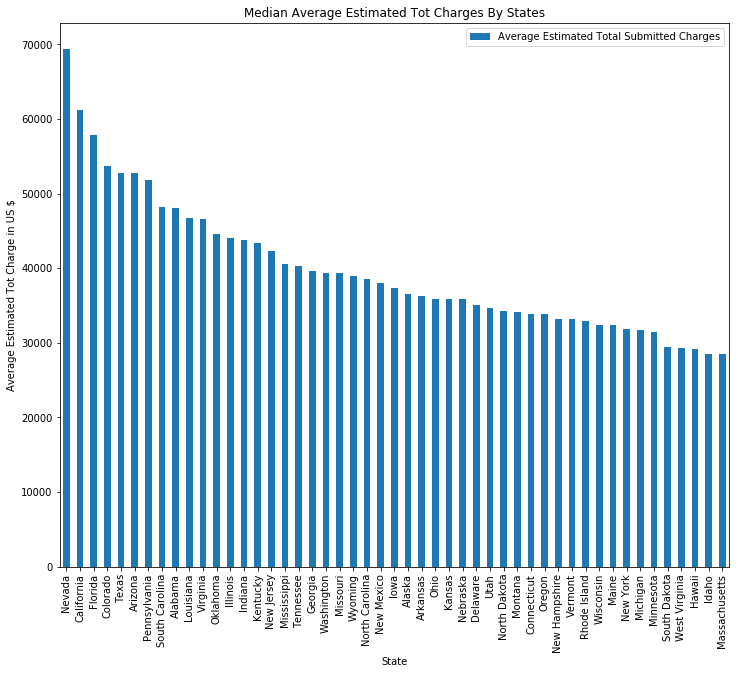

In [283]:
# median Average charge by State
merged_df[['State','Average Estimated Total Submitted Charges']].groupby('State').median().sort_values('Average Estimated Total Submitted Charges',ascending=False).plot(kind='bar')
plt.ylabel('Average Estimated Tot Charge in US $')
plt.title('Median Average Estimated Tot Charges By States')

In [284]:
import geopandas as gpd
import folium

In [285]:
location=pd.read_csv('data/statelatlong.csv')
location.head()

,State,Latitude,Longitude,City
0,AL,32.601011,-86.680736,Alabama
1,AK,61.302501,-158.775020,Alaska
2,AZ,34.168219,-111.930907,Arizona
3,AR,34.751928,-92.131378,Arkansas
4,CA,37.271875,-119.270415,California


In [286]:
# remove space at beginning from colum values using regex
#merged_df['ProcedureName']=merged_df['ProcedureName'].replace('^\s+','',regex=True)
#merged_df['ProcedureName'].unique()

In [287]:
# remove space at end from colum values
#merged_df['ProcedureName']=merged_df['ProcedureName'].replace('\s+$','',regex=True)
#merged_df['ProcedureName'].unique()

In [288]:
# calculate the difference between the average estimated total sumbitted charges and 
#merged_df['submitted_allowed_diff']=(merged_df['Average Estimated Total Submitted Charges']-merged_df['Average Medicare Allowed Amount'])

In [289]:
#merged_df['submitted_allowed_diff'].sum()


Text(0,0.5,'amount in US $')

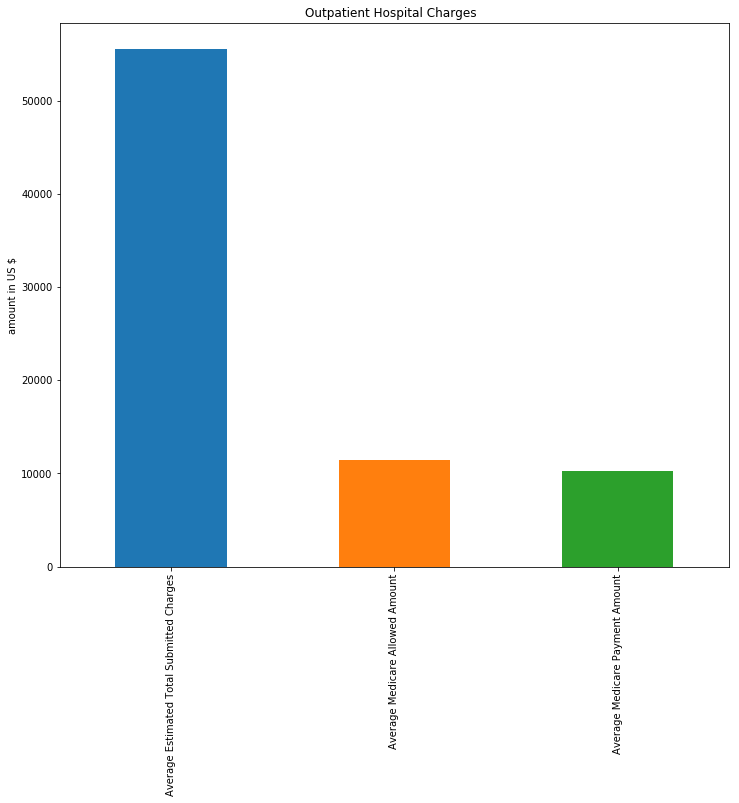

In [290]:
# plot hospital charges, medicare allowed amount, and medicare payments
OutPatmedicarecharge.iloc[:,10:13].describe().iloc[1,0:4].plot(kind='bar')
plt.title('Outpatient Hospital Charges  ')
plt.ylabel("amount in US $")

In [291]:
# create Tennessee and FLorida
OutPatmedicarecharge_TN=merged_df[merged_df['Provider State'].str.contains('TN')]
OutPatmedicarecharge_FL=merged_df[merged_df['Provider State'].str.contains('FL')]

In [292]:
OutPatmedicarecharge_TN.columns

Index(['State', 'Provider State', 'Provider Zip Code', 'County', 'Provider ID',
       'Provider Name', 'Provider Street Address', 'Provider City',
       'Provider HRR', 'APC', 'APC Description', 'Comprehensive APC Services',
       'Average Estimated Total Submitted Charges',
       'Average Medicare Allowed Amount', 'Average Medicare Payment Amount',
       'Outlier Comprehensive APC Services', 'Average Medicare Outlier Amount',
       'ProcedureName', 'Level'],
      dtype='object')

In [293]:
# distribution
OutPatmedicarecharge_heartProc=OutPatmedicarecharge_TN[OutPatmedicarecharge_TN['APC Description']=='Level 3 Endovascular Procedures']
OutPatmedicarecharge_heartProc.iloc[:,12:15].plot(kind='box')
plt.title('Distribution of Outpatient Charges by Hospitals for Level 3 Endovascular Procedures in Tennessee')
plt.ylabel("amount in US $")

TypeError: Empty 'DataFrame': no numeric data to plot

In [ ]:
OutPatmedicarecharge_heartProc=merged_df[merged_df['APC Description']=='Level 3 Endovascular Procedures']
OutPatmedicarecharge_heartProc.iloc[:,12:15].plot(kind='box')
plt.title('Distribution of Outpatient Charges by Hospitals for Level 3 Endovascular Procedures in USA')
plt.ylabel("amount in US $")

In [ ]:
# Tennessee charges 
# take neccesary columns
OutPatmedcharge_TN=OutPatmedicarecharge_TN.iloc[:,9:17]
OutPatmedcharge_descStat_TN= OutPatmedcharge_TN.describe()
# plot variation in Medicare payments
OutPatmedcharge_descStat_TN.iloc[1,2:5].plot(kind='bar')
plt.xlabel('Charges and Medicare Payments Categories')
plt.ylabel('amount in US dollars ')
plt.title("Variations in Average Providers Sumbitted Charges and Medicare Payments in Tennessee")


In [ ]:
OutPatmedicarecharge_heartProc=OutPatmedicarecharge_FL[OutPatmedicarecharge_FL['APC Description']=='Level 3 Endovascular Procedures']
OutPatmedicarecharge_heartProc.iloc[:,12:15].plot(kind='box')
plt.title('Distribution of Outpatient Charges by Hospitals for Level 3 Endovascular Procedures in Florida')
plt.ylabel("amount in US $")

In [ ]:
# plot Florida Medicare charges

OutPatmedicarecharge_FL=OutPatmedicarecharge_FL.iloc[:,9:17]
OutPatmedcharge_descStat_FL= OutPatmedicarecharge_FL.describe()
# plot variation in Medicare payments
OutPatmedcharge_descStat_FL.iloc[1,2:5].plot(kind='bar')
plt.xlabel('Charges and Medicare Payments Categories')
plt.ylabel('amount in US dollars ')
plt.title("Variations in Average Providers Sumbitted Charges and Medicare Payments in FLorida")

In [ ]:
# charges variation in Tennesse for Endovascular Procedures

OutPatmedicarecharge_TN_sorted=OutPatmedicarecharge_TN.sort_values('Average Estimated Total Submitted Charges',ascending= False)
OutPatmedicarecharge_TN_sorted= OutPatmedicarecharge_TN_sorted[OutPatmedicarecharge_TN_sorted.ProcedureName=='Endovascular Procedures']
OutPatmedicarecharge_TN_sorted.head()


In [ ]:

plt.bar(x=OutPatmedicarecharge_TN_sorted['Provider Name'],height= OutPatmedicarecharge_TN_sorted['Average Estimated Total Submitted Charges'])
plt.xticks(rotation='vertical')

plt.show()

# also try to control level, by creating level column. 

In [ ]:
# check variation by levels
OutPatmedicarecharge_TN_complex=OutPatmedicarecharge_TN_sorted[OutPatmedicarecharge_TN_sorted.Level>=3]
OutPatmedicarecharge_TN_Normal=OutPatmedicarecharge_TN_sorted[OutPatmedicarecharge_TN_sorted.Level<3]

In [ ]:
plt.bar(x=OutPatmedicarecharge_TN_complex['Provider Name'],height= OutPatmedicarecharge_TN_complex['Average Estimated Total Submitted Charges'])
plt.xticks(rotation='vertical')

plt.show()

In [ ]:
# calculate median number of Procedures and Average tot sumbitted charges
OutPatmedcharge_median=merged_df[['State','Comprehensive APC Services','Average Estimated Total Submitted Charges']].groupby('State').median().sort_values('Average Estimated Total Submitted Charges',ascending=False)

In [ ]:
OutPatmedcharge_median.head()

In [ ]:
#plt.scatter(OutPatmedcharge_median['Comprehensive APC Services'],OutPatmedcharge_median['submitted_allowed_diff'])
OutPatmedcharge_median.plot(x='Comprehensive APC Services',y='Average Estimated Total Submitted Charges',kind="scatter")
plt.xlabel('# of Comprehensive APC Services')

In [ ]:
OutPatmedicarecharge['APC Description'].unique()

In [ ]:
# Median differences in submitted and allowed charges by states
#OutPatmedicarecharge[['Provider State' ,'submitted_allowed_diff']].groupby('Provider State').median().sort_values('submitted_allowed_diff',ascending=False)

In [ ]:
# total differences in submitted and allowed charges by APC categories
#(OutPatmedicarecharge[['APC Description' ,'submitted_allowed_diff']].groupby('APC Description').sum()/1000000).sort_values('submitted_allowed_diff',ascending=False)

In [ ]:
#OutPatmedicarecharge[['Provider City' ,'submitted_allowed_diff']].groupby('Provider City').sum().sort_values('submitted_allowed_diff',ascending=False)

In [ ]:
OutPatmedicarecharge.columns

In [ ]:
# plot charges by category of procedurs 
OutPatmedcharge_Proc=merged_df[['Provider State','ProcedureName','Average Estimated Total Submitted Charges',
       'Average Medicare Allowed Amount', 'Average Medicare Payment Amount']]
OutPatmedcharge_byProcedure=OutPatmedcharge_Proc.groupby('ProcedureName').median().sort_values('Average Estimated Total Submitted Charges', ascending=False)
OutPatmedcharge_byProcedure.head(10)

OutPatmedcharge_byProcedure.plot(kind='bar')
plt.title('Charges by Type of Procedures')
plt.xlabel('Procedure Type')
plt.ylabel('amount in US $')

In [ ]:
31,833,937,266,851

In [ ]:
inpatPatmedicarecharge=pd.read_csv('data/State_Summary_of_Inpatient_Charge_Data_by_Medicare_Severity_Diagnosis_Related_Group__MS-DRG___FY2015.csv')

In [ ]:
#inpatPatmedicarecharge.info()

In [ ]:
#inpatPatmedicarecharge.columns

In [ ]:
#inpatPatmedicarecharge['charges_totpayment_diff']=(inpatPatmedicarecharge['Average Covered Charges']-inpatPatmedicarecharge['Average Total Payments'])
#inpatPatmedicarecharge.head()

In [ ]:
#inpatPatmedicarecharge.columns

In [ ]:
#inPatmedcharge=inpatPatmedicarecharge.iloc[:,3:6]
#inPatmedcharge_descStat= inPatmedcharge.describe()
#inPatmedcharge_descStat.iloc[1,:].plot(kind='bar')



In [ ]:
#inPatmedcharge.plot(kind='box')
#plt.xticks(rotation='vertical')
#plt.show()

In [ ]:
#inpatPatmedicarecharge[[' Total Discharges ','charges_totpayment_diff']].corr()

In [ ]:
#inpatPatmedicarecharge.plot(x=' Total Discharges ',y='charges_totpayment_diff',kind='scatter',logx=True)


In [ ]:
#inpatPatmedicarecharge.plot(x=' Total Discharges ',y='Average Covered Charges',kind='scatter',logx=True)


In [ ]:
#inpatPatmedicarecharge['charges_totpayment_diff'].plot(kind='hist',bins=20)

### compare mean variation in medicare payments and hospital charges by State 
### compare mean variation in medicare payments and hospital charges by State and DRG

In [ ]:
#OutpatPatientByState_df=(OutPatmedicarecharge[['Provider State' ,'submitted_allowed_diff']].groupby('Provider State').mean()/1000).sort_values('submitted_allowed_diff',ascending=False)

# group by State
#OutpatPatientByState_df.plot(kind='bar')

In [ ]:
# group by State
#inpatPatientByState_df=(inpatPatmedicarecharge[['Provider State','charges_totpayment_diff']].groupby('Provider State').mean()/1000).sort_values('charges_totpayment_diff',ascending=False)
# group by State
# inpatPatientByState_df.plot(kind='bar')

In [ ]:
#inpatPatientByState_boxdf=inpatPatmedicarecharge[['Provider State','charges_totpayment_diff']]
#inpatPatientByState_boxdf.groupby('Provider State').mean().plot(kind='box')


In [ ]:
#inpatPatientCharge_boxdf=inpatPatmedicarecharge[['Provider State','charges_totpayment_diff']]
#inpatPatientCharge_boxdf.plot(kind='box')

In [ ]:
#inpatPatientByState_df.head(20)

In [ ]:
#inpatPatientByState_boxdf.describe()

In [ ]:
# group by DRG

# inpatPatientByDRG_df=inpatPatmedicarecharge[['DRG Definition','charges_totpayment_diff']].groupby('DRG Definition').mean().sort_values('charges_totpayment_diff',ascending=False)
# group by State
# inpatPatientByDRG_df.head(10).plot(kind='bar')

In [ ]:
# inpatPatmedicarecharge_bxdf=inpatPatmedicarecharge[['DRG Definition','charges_totpayment_diff']].groupby('DRG Definition').head(20)
# inpatPatmedicarecharge_bxdf.plot(kind='box')

In [ ]:
# find top 10 DRG
#inpatPatientTop10_DRG=inpatPatientByDRG_df.head(10)
#inpatPatientTop10_DRG=inpatPatientTop10_DRG.reset_index('DRG Definition')
#Top10_DRG=inpatPatientTop10_DRG['DRG Definition'].unique()

In [ ]:
# find top 10 state
#inpatPatientTop10_state=inpatPatientByState_df.head(10)
#inpatPatientTop10_state=inpatPatientTop10_state.reset_index('Provider State')
#Top10_state=inpatPatientTop10_state['Provider State'].unique()

In [ ]:
#Top10_state

In [ ]:
# group by state and DRG 

#inpatPatient_State_DRG=inpatPatmedicarecharge[['Provider State','DRG Definition' ,'charges_totpayment_diff']].groupby(['Provider State','DRG Definition']).sum().sort_values(by=['Provider State','charges_totpayment_diff'],ascending=False)

# reset index 

#inpatPatient_State_DRG=inpatPatient_State_DRG.reset_index()

In [ ]:
#Top10_state_DRG=inpatPatient_State_DRG[(inpatPatient_State_DRG['Provider State'].isin(Top10_state)) & (inpatPatient_State_DRG['DRG Definition'].isin(Top10_DRG))]

#Top10_state_DRG[Top10_state_DRG['Provider State']=='FL'].reset_index()

In [ ]:
#Top10_state_DRG

In [ ]:
# import county health ranking data 

countyhealthrank_df=pd.read_excel('data/2016 County Health Rankings Data - v3.xls',sheet_name='Additional Measure Data', index_col=0,skiprows=1)

In [ ]:
countyhealthrank_df.columns

### my variables= ['State','County','Age-Adjusted Mortality','% 65 and over','Child Mortality Rate','% African American', '% Non-Hispanic White','Household Income','Other PCP Rate','% Uninsured','# Motor Vehicle Deaths','# Drug Overdose Deaths','Drug Overdose Mortality Rate','MV Mortality Rate','% Limited Access','% Diabetic','% Frequent Mental Distress']


In [ ]:
healthranking_df=countyhealthrank_df[['State','County','Age-Adjusted Mortality','% 65 and over','Child Mortality Rate','% African American', '% Non-Hispanic White','Household Income','Other PCP Rate','% Uninsured adults','% Uninsured children','# Motor Vehicle Deaths','# Drug Overdose Deaths','Drug Overdose Mortality Rate','MV Mortality Rate','% Limited Access to Healthy Foods','% Diabetic','% Frequent Mental Distress','% Rural']]


In [ ]:
healthranking_df.columns

In [ ]:
healthranking_df.shape

In [ ]:
# keep only desired columns
merged_df.head()


In [ ]:
# group by State and County 
hospitalCharge=merged_df[['State','County','Average Estimated Total Submitted Charges']].groupby(['State','County']).mean()
hospitalCharge.head()

In [ ]:
# reset index 
hospitalCharge=hospitalCharge.reset_index()
hospitalCharge.head()

In [ ]:
healthranking_df.groupby('County')['County'].count().to_dict()

In [ ]:
hospitalCharge['County']=hospitalCharge.County.str.strip()

In [ ]:
combined_df=pd.merge(hospitalCharge,healthranking_df,how='left',on=['State','County'])
combined_df.head()

In [ ]:
# plot relationship between rural  % of communities and hospital charges

In [ ]:
plt.scatter(combined_df['% Rural'],combined_df['Average Estimated Total Submitted Charges'])
plt.title('Relationship between Hospital Charges and Percentage of Rural Communities in a County')
plt.ylabel('hospital charges in US $')
plt.xlabel('percentage of Rural communities')

In [ ]:
plt.scatter(combined_df['% 65 and over'],combined_df['Average Estimated Total Submitted Charges'])
plt.title('Relationship between Hospital Charges and Percentage of Over 65 Population')
plt.ylabel('hospital charges in US $')
plt.xlabel('percentage of Over 65 Population')

In [ ]:
plt.scatter(combined_df['Other PCP Rate'],combined_df['Average Estimated Total Submitted Charges'])
plt.title('Relationship between Hospital Charges and Other PCP Rate')
plt.ylabel('hospital charges in US $')
plt.xlabel('Other PCP Rate')

In [ ]:
plt.scatter(combined_df['% Uninsured adults'],combined_df['Average Estimated Total Submitted Charges'])
plt.title('Relationship between Hospital Charges and Percentage of Uninsured adults')
plt.ylabel('hospital charges in US $')
plt.xlabel('percentage of Uninsured adults')

In [ ]:
plt.scatter(combined_df['% Limited Access to Healthy Foods'],combined_df['Average Estimated Total Submitted Charges'])
plt.title('Relationship between Hospital Charges and Percentage of Limited Access to Healthy Foods')
plt.ylabel('hospital charges in US $')
plt.xlabel('% of Population With Limited Access to Healthy Foods')

In [ ]:
combined_df.columns

In [ ]:
hospitalCharge['County'].to_dict()

In [ ]:
salary=pd.read_excel("data/state_M2016_dl.xlsx")

salary.head()

In [ ]:
salary=salary[salary.OCC_TITLE=='Physicians and Surgeons, All Other']

In [ ]:
salary=salary[['STATE','OCC_TITLE','A_MEAN']]
salary.columns=['State','OCC_TITLE','AveYearlySalary']

In [ ]:
salary.sort_values('AveYearlySalary',ascending=False).plot(kind='bar',x='State',y='AveYearlySalary')

In [ ]:
# merge salary data
#combined_data=pd.merge(combined_df,salary, how='left',on='State')
#combined_data.columns

In [ ]:
# import linear regression model
import scipy.stats as stats
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import preprocessing  # helps for reshaping X and y
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from scipy import stats

In [ ]:
combined_df.shape

In [ ]:
combined_df=combined_df.dropna(axis=0)

In [ ]:
combined_df['Other PCP Rate']=pd.to_numeric(combined_df['Other PCP Rate'])

In [ ]:
combined_df.info()

In [ ]:
# define X and y variables
y=combined_df.iloc[:,2]
#X=combined_df.iloc[:,3:21]
# 
#X=combined_df.iloc[:,-1]abs
X=combined_df[['% Uninsured adults','% Rural','% 65 and over']]


In [ ]:
X.head()

In [ ]:
# reshape it becuase it is only one feature
#X=X.values.reshape(-1,1)


#X=combined_df[['% 65 and over','Child Mortality Rate',
       '% African American','Household Income',
       'Other PCP Rate', '% Uninsured adults', '% Uninsured children',
       '# Motor Vehicle Deaths', '# Drug Overdose Deaths',
       'Drug Overdose Mortality Rate', 'MV Mortality Rate',
       '% Limited Access to Healthy Foods', '% Diabetic',
       '% Frequent Mental Distress']]

In [ ]:
y.head()

In [ ]:
# split the data into train and test, 33% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


In [ ]:
# define the model
lmodel=LinearRegression()
lmodel.fit(X_train,y_train)
# predict the model
y_pred=lmodel.predict(X_test)


In [ ]:
print('R score: %.2f' % r2_score(y_test, y_pred))
print ('Mean Square Error:%.2f' % mean_squared_error(y_test,y_pred))

In [ ]:
lmodel.coef_

### % of Uninsured population in the counties has positively  related with hospital charges
### 1 % increase in % of uninsured increases  charge increses hospital charges by $588


### 1% increase in proportion of Rural communities in the counties decreases hospital charges by $346

In [ ]:
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

In [ ]:
# tried  OLS model  selected variables by county level

# define y
# define X and y variables
y=combined_df.iloc[:,2]

X=  combined_df[['% 65 and over','% Non-Hispanic White', 'Household Income',
       '% Uninsured adults', '% Uninsured children', '# Motor Vehicle Deaths','# Drug Overdose Deaths', '% Limited Access to Healthy Foods', '% Diabetic','Other PCP Rate','% Rural']]

In [ ]:
X.info()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
# define the model
lmodel_st=LinearRegression()
lmodel_st.fit(X_train,y_train)
# predict the model
y_pred=lmodel_st.predict(X_test)
print('R score: %.2f' % r2_score(y_test, y_pred))
print ('Mean Square Error:%.2f' % mean_squared_error(y_test,y_pred))
lmodel_st.coef_

### - Limited access to healthy food is highly associated particularly with  those living in low-income neighborhoods,communities of color, and rural areas
### - This could be a possible explanation why it has negative effect on hospital charges. 

In [ ]:
X2 = sm.add_constant(X)

est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

In [ ]:
combined_df[combined_df['% Rural']>60.00].shape

In [ ]:
# group the data by state
combined_State_df=combined_df.drop('County',axis=1).groupby('State').mean()
combined_State_df.head()


In [ ]:
# keep only Salary amoount column
salary_amt=salary.drop('OCC_TITLE',axis=1)
# combined State data with Salary data

combined_State_all=pd.merge(combined_State_df,salary_amt, how='left', on='State')
combined_State_all.head()

In [ ]:
combined_State_all=combined_State_all.dropna(axis=0)

### - I tried a model including Salary for physicians and surgeons, but the salary has negative sign , but not significant effect.
### - Logically Physicians  can move from State to can minimize the variations in Salary, so this cannot be real explaining factor for variations in hospital charges.

In [ ]:
# define y
y=combined_State_all.iloc[:,1]
# define X 
# only % uninsured and %Rural, both are have statistically significant effect.

#X=combined_State_all[['% Uninsured adults','% Rural']]

# added average Physicians and surgeons salary by state, Salary is not statistically significant

#X=combined_State_all[['% 65 and over','% Uninsured adults','% Rural','AveYearlySalary']]
# tried will all variables, except salary
X=combined_State_all.iloc[:,2:18]

In [ ]:
#X['AveYearlySalary']=pd.to_numeric(X.AveYearlySalary)

In [ ]:
X.info()

In [ ]:
y.head()

In [ ]:
# split the data into train and test, 33% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
# define the model
lmodel_st=LinearRegression()
lmodel_st.fit(X_train,y_train)
# predict the model
y_pred=lmodel_st.predict(X_test)

In [ ]:
print('R score: %.2f' % r2_score(y_test, y_pred))
print ('Mean Square Error:%.2f' % mean_squared_error(y_test,y_pred))
lmodel_st.coef_

In [ ]:
# USE OLS Linear Regression 
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()

print(est2.summary())


In [ ]:
# tried  OLS model  selected variables

# define y
y=combined_State_all.iloc[:,1]

X=  combined_State_all[['Child Mortality Rate', '% Non-Hispanic White', 'Household Income',
       '% Uninsured adults', '% Uninsured children', '# Motor Vehicle Deaths','# Drug Overdose Deaths', '% Limited Access to Healthy Foods', '% Diabetic','% Frequent Mental Distress', '% Rural']]

In [ ]:
X.columns

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
# define the model
lmodel_st=LinearRegression()
lmodel_st.fit(X_train,y_train)
# predict the model
y_pred=lmodel_st.predict(X_test)
print('R score: %.2f' % r2_score(y_test, y_pred))
print ('Mean Square Error:%.2f' % mean_squared_error(y_test,y_pred))
lmodel_st.coef_

In [ ]:
# OlS for selected variables
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()

print(est2.summary())


In [ ]:
combined_State_O65=combined_State_all.sort_values('% 65 and over',ascending=False)
plt.bar(x=combined_State_O65.State,height=combined_State_O65['% 65 and over'])
plt.xticks(rotation='vertical')
plt.show()

### To do Today

- Try create Rural Urben Data
- create system non system

- run only rural or urban data 

### combibe Hospital Information data with combined_df

In [ ]:
state_median_charge=combined_State_all.iloc[:,0:2]
state_median_charge.head()

In [ ]:
import csv

In [ ]:
state_median_charge.to_csv('data/state_median_charge.csv',index=False)